# Summary



### Parameter files

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    pr_filenames = ['HamiltonianExploration_sinbeta_eta0p25']
#     pr_filenames = ['HamiltonianExploration_sinbeta_eta0p5']
#     pr_filenames = ['HamiltonianExploration_sinbeta_eta1p5']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

### Preliminaries

In [2]:
# Import Sympy and Numpy and set up latex inline & pretty dict printing
import sympy as sy, numpy as np
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import Matrix, Eq, lambdify, poly, \
    simplify, factor, expand, cancel, collect, expand_trig, \
    sin,cos,tan,sec, atan, Rational, sqrt, solve, Abs, N, re, im
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters
from gmplib.plot_utils import GraphingBase

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.symbols import *
from gme.equations import Equations
# from gme.ode_raytracing import OneRaySolution
from gme.plot import OneRayPlots

import matplotlib as mpl, matplotlib.pyplot as plt
mpl.rc('font', size=14, family='Arial')
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.ticker import MaxNLocator

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','Theory')
pr_path, pr_filenames

Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/Theory',
 ['HamiltonianExploration_sinbeta_eta0p25'])

In [4]:
parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
evaluations = {}
evaluations_sequence = ()
pr = Parameters(parameters_dict, evaluations=evaluations, sequence=evaluations_sequence)
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'Theory',
    'short_name': 'hamiltonian',
    'subtitle': '',
    'title': 'Exploration of Hamiltonian for sin(beta) erosion model, eta=1/4',
    'verbose': True,
    'very_verbose': False}
{   'Lc': 10000,
    'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 1/4,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 1/2,
    't_xiv0_list': None,
    'varepsilon': 1/1000,
    'varepsilonhat': 1/100,
    'varphi_0': 2.641e-05,
    'varphi_type': 'ramp',
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': 1000}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {   'Hamilton': 'DOP853',
                  'choices': ['RK45', 'RK23', 'Radau', 'DOP853', 'LSODA'],
                  'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
    't_end': 0.01,
    'vb_res': 101}
{   'do_eliminat

In [5]:
pr.model.varphi_0 = 0.1
pr.model.xiv_0 = 1

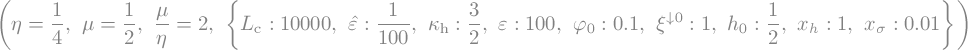

In [6]:
sub = {
        Ci: pr.model.Ci, 
        Lc: pr.model.Lc, 
        varepsilonhat: pr.model.varepsilonhat, 
        varepsilon: pr.model.varepsilonhat*pr.model.Lc, 
        varphi_0: pr.model.varphi_0,
        xiv_0: pr.model.xiv_0
}
Eq(eta,pr.model.eta), Eq(mu,pr.model.mu), Eq(mu/eta,pr.model.mu/pr.model.eta), sub

# Theory

## Basics

In [7]:
def eqns(eqn_list):
    return [getattr(gmeq, eqn) for eqn in eqn_list]

In [8]:
gmeq = Equations( eta=pr.model.eta, 
                  mu=pr.model.mu, 
                  beta_type=pr.model.beta_type, 
                  varphi_type=pr.model.varphi_type, 
                  ibc_type=pr.model.ibc_type,
                  do_idtx=False,
                  do_geodesic=False, 
                  parameters=sub, 
                  do_raw=True )

In [9]:
prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta', gmeq.varphi_type.replace('-','')])

suffix = f'_eta{float(sy.N(gmeq.eta))}'
suffix += f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.2f}' if gmeq.mu/gmeq.eta==Rational(1,3) \
                                    else f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.1f}'
suffix += f'_xiv{float(sy.N(pr.model.xiv_0)):1.0f}'
suffix = (suffix if pr.model.varphi_type=='ramp' \
            else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}').replace('.','p')

job_name = prefix+suffix
job_name

'hamiltonian_sinbeta_ramp_eta0p25_ratio2p0_xiv1'

## Hamiltonian

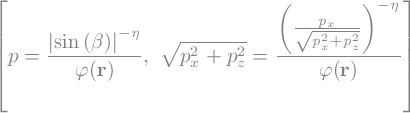

In [10]:
eqns(['p_varphi_beta_eqn', 'p_varphi_pxpz_eqn'])

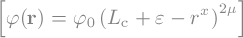

In [11]:
eqns(['varphi_rx_eqn'])

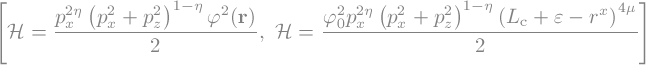

In [12]:
eqns(['H_eqn', 'H_varphi_rx_eqn'])

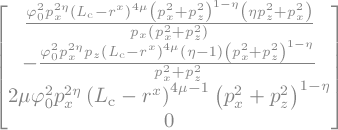

In [13]:
gmeq.hamiltons_eqns.subs({varepsilon:0})

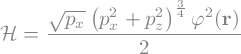

In [14]:
H_from_gstar_eqn = Eq(H, factor( simplify( 
    (gmeq.p_covec_eqn.rhs*(gmeq.gstar_varphi_pxpz_eqn.rhs * gmeq.p_covec_eqn.rhs.T))[0]/2 ) ) )
H_from_gstar_eqn

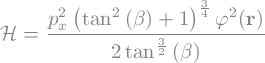

In [15]:
H_tanbeta_px_eqn = factor( H_from_gstar_eqn
                              .subs(e2d(gmeq.pz_px_tanbeta_eqn)) ) \
                        .subs({Abs(tan(beta)):tan(beta), Abs(px):px})
H_tanbeta_px_eqn

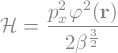

In [16]:
H_smallbeta_px_eqn = simplify(H_tanbeta_px_eqn).subs({cos(beta):1, tan(beta):beta})
H_smallbeta_px_eqn

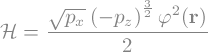

In [17]:
H_from_gstar_eqn.subs({px**2+pz**2:pz**2})

In [18]:
varphi_rx_eqn = gmeq.varphi_rx_eqn.subs({mu:pr.model.mu}).subs(sub)
varphi_rx_eqn

In [19]:
Eq(pz,(pz_0).subs(e2d(gmeq.pz0_xiv0_eqn)).subs(sub))

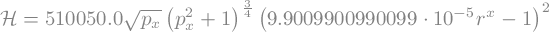

In [20]:
H_px_rx_eqn = simplify(
    H_from_gstar_eqn.subs(e2d(varphi_rx_eqn))
    .subs({pz:pz_0}).subs(e2d(gmeq.pz0_xiv0_eqn)).subs(sub)
)
H_px_rx_lambda = lambdify( (rx,px), H_px_rx_eqn.rhs)
H_px_rx_eqn

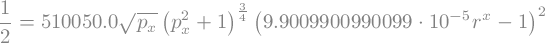

In [21]:
H_px_rx_eqn.subs({H:Rational(1,2)})

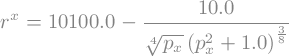

In [22]:
rx_px_eqn = Eq(rx, (solve(H_px_rx_eqn.subs({H:Rational(1,2)}),rx))[0])
rx_px_lambda = lambdify( px, (rx_px_eqn.rhs) )
rx_px_eqn

## Visualize Hamiltonian level-sets

In [23]:
gr = GraphingBase()

In [24]:
n_rx_pts = pr.plot.n_rx_pts
n_px_pts = pr.plot.n_px_pts
n_levels = pr.plot.n_levels
n_levels

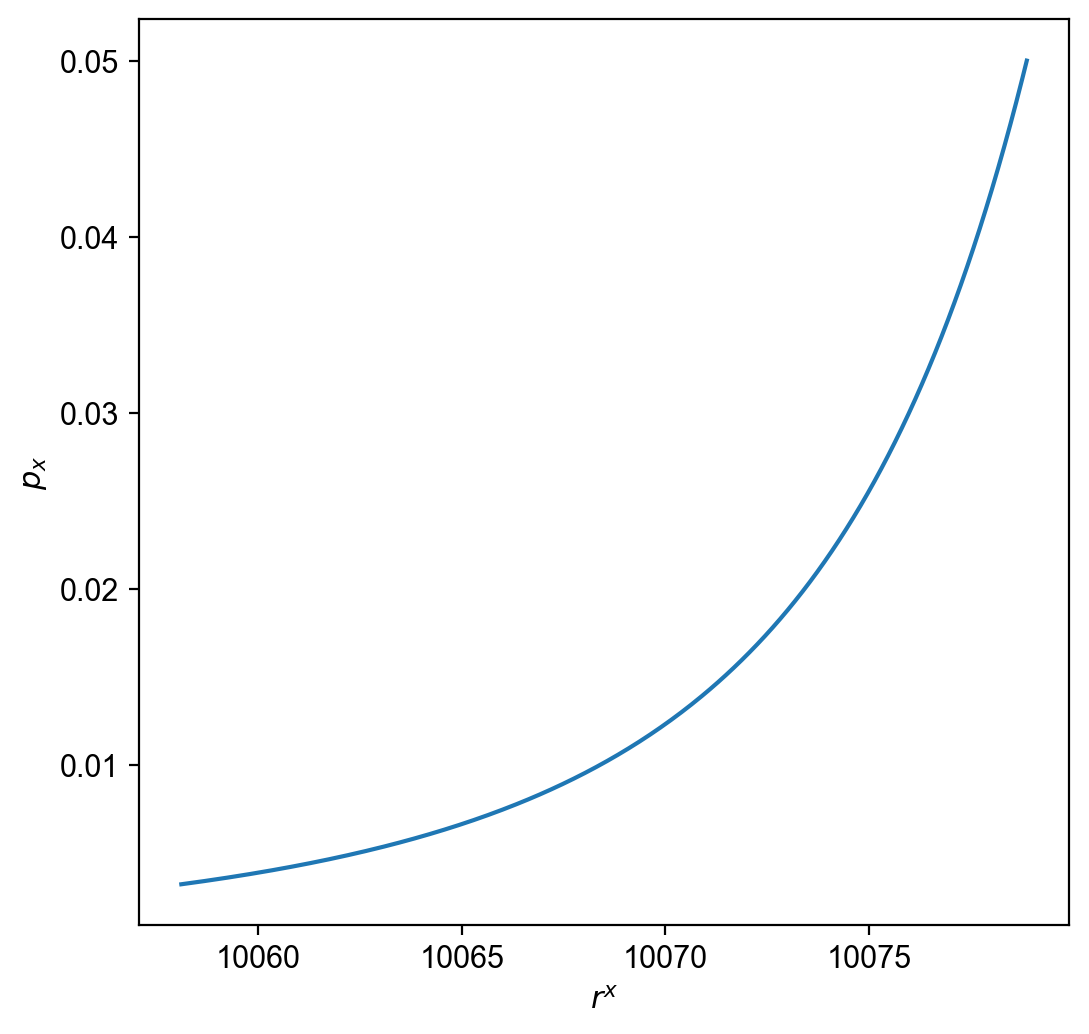

In [25]:
fig = gr.create_figure(job_name+'_H_levelset', fig_size=(6,6))
px_min, px_max = pr.plot.px_min, pr.plot.px_max
px_array = np.exp(np.linspace(np.log(px_min),np.log(px_max),n_px_pts))
rx_array = np.array([ float(rx_px_lambda(px_)) for px_ in px_array])
plt.plot(rx_array, px_array);
plt.xlabel(r'$r^x$')
plt.ylabel(r'$p_x$');

In [26]:
px_array = np.exp(np.linspace(np.log(0.001),np.log(px_max),n_px_pts))
rx_array = np.linspace(0,1,n_rx_pts)
rx_meshgrid, px_meshgrid = np.meshgrid(rx_array, px_array, sparse=False, indexing='ij')
H_array = np.array([[float(H_px_rx_lambda(rx_,px_)) for px_ in px_array] for rx_ in rx_array])
logH_array = np.log10(2*H_array)
logH_array = logH_array - np.min(logH_array)

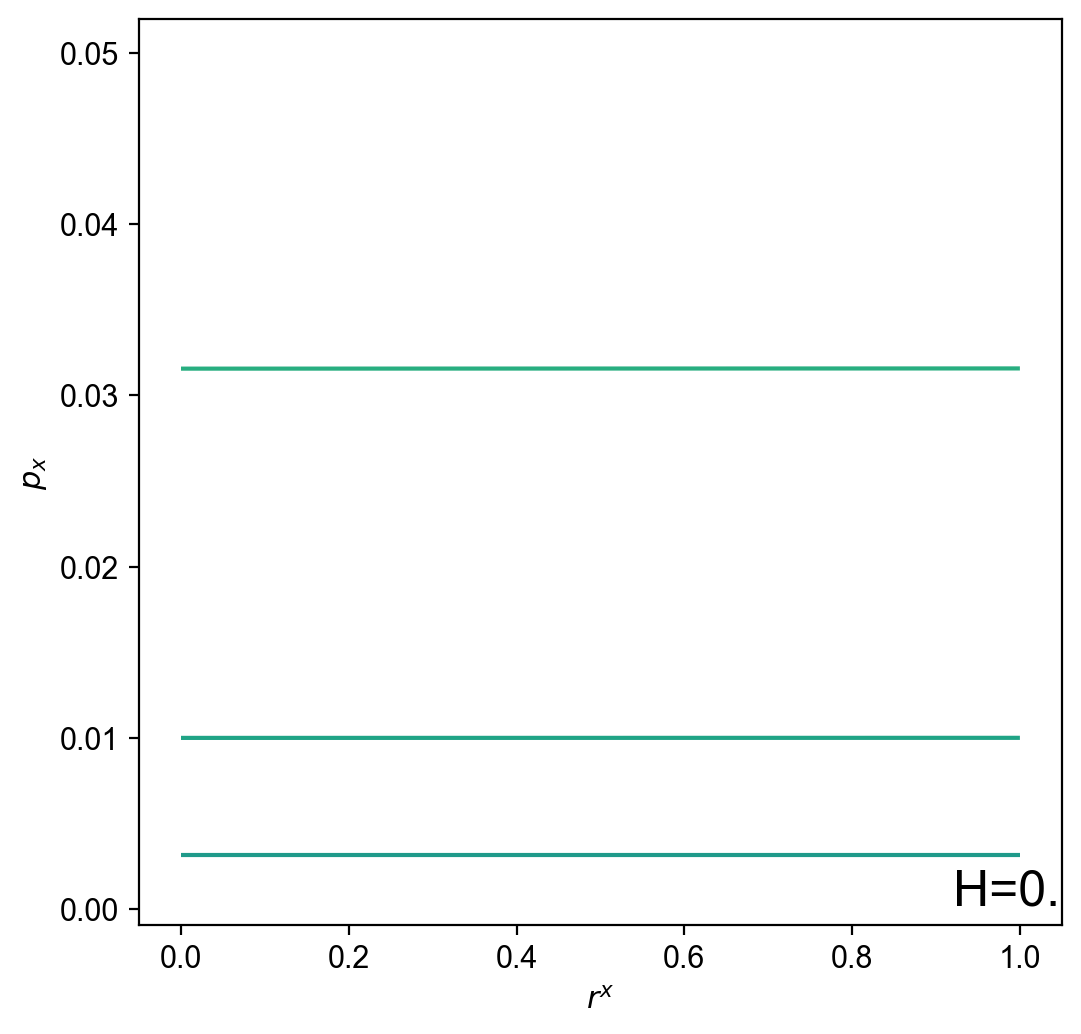

In [27]:
fig = gr.create_figure(job_name+'_H_contourlines', fig_size=(6,6))
# fig = plt.figure(figsize=(8,8),)
levels = np.linspace(-3,3,7+6*3)
levels = np.delete(levels,len(levels)//2)
label_levels = np.array([-1,1,2,3])

fmt = lambda log2H: rf'H={10**(log2H)/2:g}'
contours = plt.contour(rx_meshgrid, px_meshgrid, logH_array, levels)
zero_contour = plt.contour(rx_meshgrid, px_meshgrid, logH_array, [0], colors='k', linewidths=2)
plt.clabel(contours, label_levels, inline=True, fmt=fmt, fontsize=13)
manual_location = [(0.8, 0.01)]
plt.clabel(zero_contour, [0], inline=True, fmt=fmt, fontsize=18, manual=manual_location)
plt.xlabel(r'$r^x$')
plt.ylabel(r'$p_x$');
plt.xlim(-0.05,1.05)
px_range = px_array[-1]-px_array[0]
plt.ylim(px_array[0]-px_range/25,px_array[-1]+px_range/25);
axes = plt.gca()
axes.set_aspect(1/(px_array[-1]-px_array[0]))

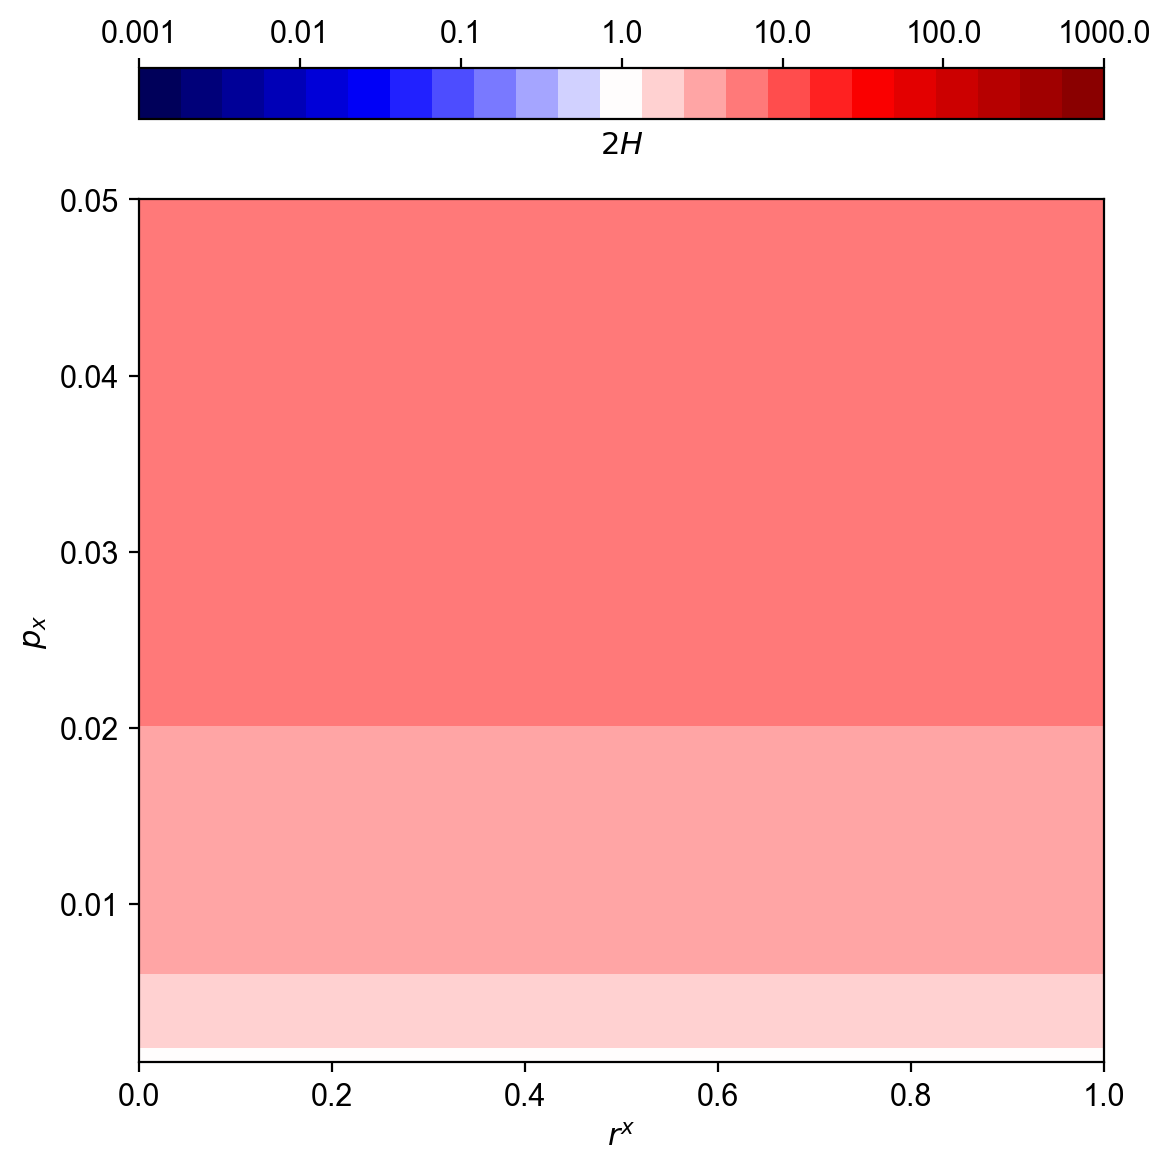

In [28]:
fig = gr.create_figure(job_name+'_H_contourcolors', fig_size=(6,6))
plt.axvspan(0,1, facecolor='k', alpha=0.2, zorder=-100)

cmap = plt.get_cmap('seismic')
# levels = MaxNLocator(nbins=n_levels).tick_values(logH_array.min(), logH_array.max())
# levels = np.linspace(-2.25,2.25,6+5*3-3+1)
levels = np.linspace(-3,3,7+6*3-1)
label_levels = np.array([-3,-2,-1,0,1,2,3])
labels = np.array([0.001,0.01,0.1,1,10,100,1000])

norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

drx, dpx = 0.01, 0.01
# cf = plt.contourf(rx_meshgrid[:-1, :-1]+drx/2, px_meshgrid[:-1, :-1]+dpx/2, 
#         H_array[:-1, :-1], levels=levels, cmap=cmap)
cf = plt.contourf(rx_meshgrid, px_meshgrid, logH_array, levels=levels, cmap=cmap)
axes = plt.gca()
plt.xlabel(r'$r^x$')
plt.ylabel(r'$p_x$');

divider = make_axes_locatable(axes)
cax = divider.append_axes('top', size='6%', pad=0.4)

cbar = fig.colorbar(cf, cax=cax, orientation='horizontal', label=r'$2H$', ticks=label_levels)
cbar.ax.set_xticklabels(labels)
cbar.ax.xaxis.set_ticks_position('top')
fig.tight_layout()

# Save

Export the graphs as PNG and/or PDF image files.

In [29]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' )

Writing to dir: "/Users/colinstark/Projects/GME/Plots/Theory"
Exported "hamiltonian_sinbeta_ramp_eta0p25_ratio2p0_xiv1_H_levelset.png"
Exported "hamiltonian_sinbeta_ramp_eta0p25_ratio2p0_xiv1_H_contourlines.png"
Exported "hamiltonian_sinbeta_ramp_eta0p25_ratio2p0_xiv1_H_contourcolors.png"
